In [157]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer, SimpleImputer

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.compose import ColumnTransformer

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from xgboost import XGBClassifier

from sklearn.pipeline import Pipeline
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix
from skopt import BayesSearchCV
#from fancyimpute import IterativeImputer
#from skopt import BayesSearchCV
import pickle
import warnings
warnings.filterwarnings('ignore')

In [158]:

description = pd.read_excel('./E Commerce Dataset.xlsx', sheet_name='Data Dict', header=1, usecols=[1,2,3])
data = pd.read_excel('./E Commerce Dataset.xlsx', sheet_name='E Comm')


# Encoder pipeline

In [159]:

X=data.drop(['Churn'],axis=1)
y=data['Churn']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=0)


skfcv=StratifiedKFold(n_splits=5)

In [160]:


cat_data = X.select_dtypes(include='object').columns.tolist()
num_data = X.select_dtypes(exclude='object').columns.tolist()

categorical_preprocessor = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False))
])

numerical_preprocessor = Pipeline([
    ('imputer',IterativeImputer(random_state=0)),
    ('scaler', StandardScaler())
])


preprocessor = ColumnTransformer([
    ('num', numerical_preprocessor, num_data),
    ('cat', categorical_preprocessor, cat_data)
])

# Model Development

In [161]:

log_pipe = Pipeline([('preprocessor', preprocessor),
                    ('logreg',LogisticRegression())])


print(f"Cross validation score for Logistic Regression: {np.mean(cross_val_score(log_pipe, X_train, y_train, cv=skfcv, scoring='f1'))}")

Cross validation score for Logistic Regression: 0.6283869731515438


Test score for Logistic Regression: 0.6567164179104478
Training score for Logistic Regression: 0.6480186480186481


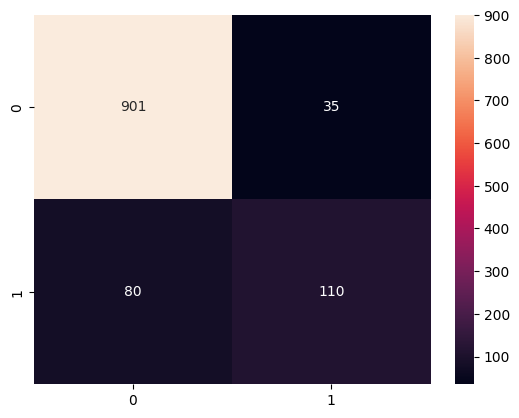

In [162]:

log_pipe.fit(X_train,y_train)

with open('log_pretrained_model.pkl', 'wb') as f:
    pickle.dump(log_pipe, f)

print(f"Test score for Logistic Regression: {f1_score(y_test, log_pipe.predict(X_test))}")
print(f"Training score for Logistic Regression: {f1_score(y_train, log_pipe.predict(X_train))}")
log_mat = confusion_matrix(y_test, log_pipe.predict(X_test))
sns.heatmap(log_mat, annot=True,fmt="g")
plt.show()

In [163]:

lda_pipe = Pipeline([('preprocessor', preprocessor), ('scaler',StandardScaler()),
                    ('lda',LinearDiscriminantAnalysis())])


print(f"Cross validation score for LinearDiscriminantAnalysis: {np.mean(cross_val_score(lda_pipe, X_train, y_train, cv=skfcv, scoring='f1'))}")

Cross validation score for LinearDiscriminantAnalysis: 0.5934973799829543


Test score for LinearDiscriminantAnalysis: 0.631578947368421
Training score for LinearDiscriminantAnalysis: 0.6073717948717948


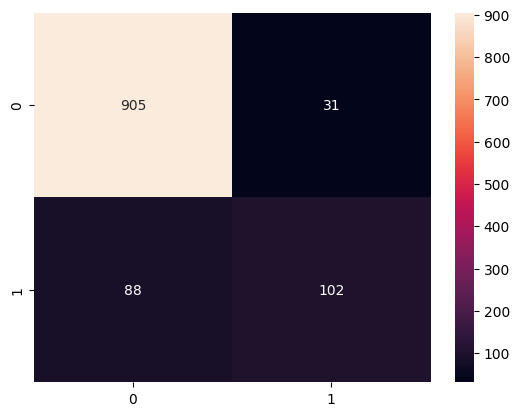

In [164]:

lda_pipe.fit(X_train,y_train)

with open('lda_pretrained_model.pkl', 'wb') as f:
    pickle.dump(lda_pipe, f)

print(f"Test score for LinearDiscriminantAnalysis: {f1_score(y_test, lda_pipe.predict(X_test))}")
print(f"Training score for LinearDiscriminantAnalysis: {f1_score(y_train, lda_pipe.predict(X_train))}")
lda_mat = confusion_matrix(y_test, lda_pipe.predict(X_test))
sns.heatmap(lda_mat, annot=True,fmt="g")
plt.show()

In [165]:

rf_pipe = Pipeline([('preprocessor', preprocessor),('scaler',StandardScaler()),
                    ('rfmodel',RandomForestClassifier())])


print(f"Cross validation score for Random Forest: {np.mean(cross_val_score(rf_pipe, X_train, y_train, cv=skfcv, scoring='f1'))}")

Cross validation score for Random Forest: 0.8053745796777123


Test score for Random Forest: 0.8767123287671232
Training score for Random Forest: 1.0


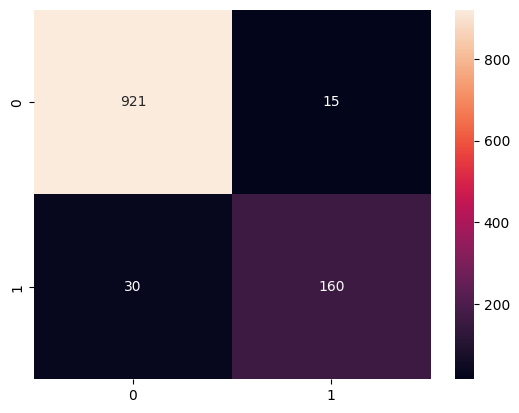

In [166]:

rf_pipe.fit(X_train,y_train)

with open('rf_pretrained_model.pkl', 'wb') as f:
    pickle.dump(rf_pipe, f)

print(f"Test score for Random Forest: {f1_score(y_test, rf_pipe.predict(X_test))}")
print(f"Training score for Random Forest: {f1_score(y_train, rf_pipe.predict(X_train))}")
rf_mat = confusion_matrix(y_test, rf_pipe.predict(X_test))
sns.heatmap(rf_mat, annot=True,fmt="g")
plt.show()

In [167]:

xgb_pipe = Pipeline([('preprocessor', preprocessor),('scaler',StandardScaler()),
                    ('xgb',XGBClassifier(verbosity=0,use_label_encoder=False))])


print(f"Cross validation score for XGBoost: {np.mean(cross_val_score(xgb_pipe, X_train, y_train, cv=skfcv, scoring='f1'))}")

Cross validation score for XGBoost: 0.8765914106319196


Test score for XGBoost: 0.9018567639257294
Training score for XGBoost: 1.0


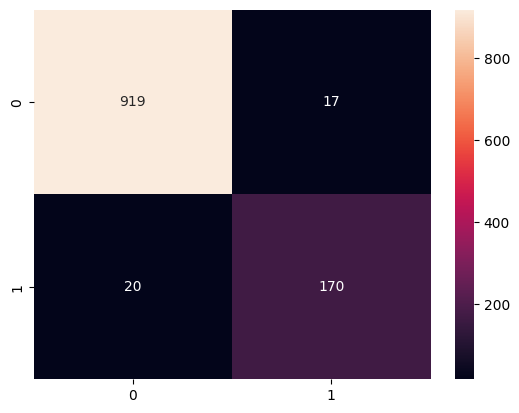

In [168]:

xgb_pipe.fit(X_train,y_train)

with open('xgb_pretrained_model.pkl', 'wb') as f:
    pickle.dump(xgb_pipe, f)

print(f"Test score for XGBoost: {f1_score(y_test, xgb_pipe.predict(X_test))}")
print(f"Training score for XGBoost: {f1_score(y_train, xgb_pipe.predict(X_train))}")
xgb_mat = confusion_matrix(y_test, xgb_pipe.predict(X_test))
sns.heatmap(xgb_mat, annot=True, fmt="g")
plt.show()

# HYPERPARAMETER TUNING

In [169]:
#create hyperparameter search space
space={'xgb__eta': (0.01,0.3),
       'xgb__max_depth': (5,11),
      'xgb__subsample': (0.4,1),
      'xgb__n_estimators': (100,250),
      'xgb__gamma':(0,5),
      'xgb__colsample_bytree':(0.4,1),
      'xgb__min_child_weight': (0.3,1)}

In [170]:
#create BayesSearchCV object
search=BayesSearchCV(xgb_pipe,search_spaces=space,n_jobs=-1,cv=skfcv, scoring='f1')

In [171]:
#fit the object to the data
search.fit(X_train, y_train)

BayesSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
              estimator=Pipeline(steps=[('preprocessor',
                                         ColumnTransformer(transformers=[('num',
                                                                          Pipeline(steps=[('imputer',
                                                                                           IterativeImputer(random_state=0)),
                                                                                          ('scaler',
                                                                                           StandardScaler())]),
                                                                          ['CustomerID',
                                                                           'Tenure',
                                                                           'CityTier',
                                                                           'WarehouseToHome',
                                                                           'HourSpendOnApp',
                                                                           'NumberOfDeviceRegistered',
                                                                           'Sati...
                                                       missing=nan,
                                                       monotone_constraints=None,
                                                       multi_strategy=None,
                                                       n_estimators=None,
                                                       n_jobs=None,
                                                       num_parallel_tree=None,
                                                       random_state=None, ...))]),
              n_jobs=-1, scoring='f1',
              search_spaces={'xgb__colsample_bytree': (0.4, 1),
                             'xgb__eta': (0.01, 0.3), 'xgb__gamma': (0, 5),
                             'xgb__max_depth': (5, 11),
                             'xgb__min_child_weight': (0.3, 1),
                             'xgb__n_estimators': (100, 250),
                             'xgb__subsample': (0.4, 1)})

In [172]:
#print the best cv score and the best parameters
print(search.best_score_)
print(search.best_params_)

0.8900563016681786
OrderedDict({'xgb__colsample_bytree': 1.0, 'xgb__eta': 0.21563596795024947, 'xgb__gamma': 0, 'xgb__max_depth': 8, 'xgb__min_child_weight': 0.3, 'xgb__n_estimators': 250, 'xgb__subsample': 1.0})


0.9315789473684211


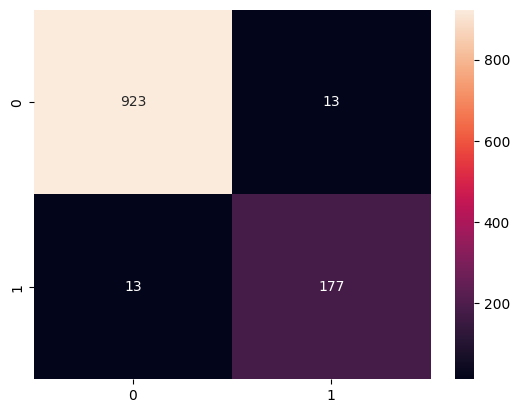

In [173]:
#use the best model parameters to predict the test sample and print the results
best_model=search.best_estimator_
print(f1_score(y_test,best_model.predict(X_test)))
sns.heatmap(confusion_matrix(y_test, best_model.predict(X_test)), annot=True, fmt="g")
plt.show()

In [174]:
feature_importance=pd.DataFrame(search.best_estimator_[2].feature_importances_, columns=['importance'])
feature_importance['features'] = X_train.columns

plt.figure(figsize=(10,8))
sns.barplot(x='importance', y='features', data=feature_importance.sort_values(by='importance', ascending=False))
plt.title('Feature importances')
plt.show()

ValueError: Length of values (19) does not match length of index (30)